# Import

https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# ! pip install  seaborn scipy==1.10.1 numpy==1.23.5 pandas==2.0.3


# PD Setting


In [4]:
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
#显示宽度
pd.set_option('display.width', 2000)

pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

In [5]:
MISSING_COLS =[]
DROP_COLS =[]
CAT_COLS =[]
NUM_COLS =[]
RATIO = 0

# Load Data

In [6]:
#load data
train_path ="./data/train.csv"
test_path="./data/test.csv"
train_data = pd.read_csv(train_path)
test_data =pd.read_csv(test_path)
print('train data size:',train_data.shape)
print('predict data size:',test_data.shape)

train data size: (595212, 59)
predict data size: (892816, 58)


# EDA

Data Description

* features that belong to similar groupings are tagged as such in the feature name e.g., ind, reg, car, calc
* feature names include the postfix bin to indicate binary features and cat to indicate categorical features.
* Features without these designations are either continuous or ordinal.
* Values of -1 indicate that the feature was missing from the observation.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [8]:
train_data.head(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0




用来表示数据中的缺失值

In [9]:
missing_values = train_data.isna().sum()
# 查看缺失值
missing_values[missing_values > 0]

Series([], dtype: int64)

In [10]:
print('***data missing num***')

for col in train_data.columns:
    m = train_data[col].isin([-1]).sum()
    if m>0:
        missing_ratio = m / len(train_data)
        print(col,':',m,'--' ,f'{missing_ratio:.4f}')
        MISSING_COLS.append(col)

print(MISSING_COLS)
        

***data missing num***
ps_ind_02_cat : 216 -- 0.0004
ps_ind_04_cat : 83 -- 0.0001
ps_ind_05_cat : 5809 -- 0.0098
ps_reg_03 : 107772 -- 0.1811
ps_car_01_cat : 107 -- 0.0002
ps_car_02_cat : 5 -- 0.0000
ps_car_03_cat : 411231 -- 0.6909
ps_car_05_cat : 266551 -- 0.4478
ps_car_07_cat : 11489 -- 0.0193
ps_car_09_cat : 569 -- 0.0010
ps_car_11 : 5 -- 0.0000
ps_car_12 : 1 -- 0.0000
ps_car_14 : 42620 -- 0.0716
['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']


ps_ind_02_cat 和 ps_ind_04_cat 与 ps_car_01_cat的缺失常同时发生；

ps_car_07_cat 和 ps_ind_05_cat 的缺失绑定；

ps_car_03_cat 和 ps_car_05_cat 常一起缺失

查看数据分布情况


In [11]:
train_data.nunique()

id                595212
target                 2
ps_ind_01              8
ps_ind_02_cat          5
ps_ind_03             12
ps_ind_04_cat          3
ps_ind_05_cat          8
ps_ind_06_bin          2
ps_ind_07_bin          2
ps_ind_08_bin          2
ps_ind_09_bin          2
ps_ind_10_bin          2
ps_ind_11_bin          2
ps_ind_12_bin          2
ps_ind_13_bin          2
ps_ind_14              5
ps_ind_15             14
ps_ind_16_bin          2
ps_ind_17_bin          2
ps_ind_18_bin          2
ps_reg_01             10
ps_reg_02             19
ps_reg_03           5013
ps_car_01_cat         13
ps_car_02_cat          3
ps_car_03_cat          3
ps_car_04_cat         10
ps_car_05_cat          3
ps_car_06_cat         18
ps_car_07_cat          3
ps_car_08_cat          2
ps_car_09_cat          6
ps_car_10_cat          3
ps_car_11_cat        104
ps_car_11              5
ps_car_12            184
ps_car_13          70482
ps_car_14            850
ps_car_15             15
ps_calc_01            10


In [12]:
col_name = 'target'
train_data[col_name].unique()

array([0, 1], dtype=int64)

In [13]:
train_data['target'].value_counts(normalize=True)*100

target
0    96.355248
1     3.644752
Name: proportion, dtype: float64

In [14]:

df_majority = train_data[train_data['target'] == 0]
df_minority = train_data[train_data['target'] == 1]

RATIO = len(df_majority)/len(df_minority)
print('RATIO:',RATIO)
# 采样多数类
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# 合并采样后的数据
train_data = pd.concat([df_majority_downsampled, df_minority], axis=0)

RATIO: 26.43671061122891


In [15]:
train_data['target'].value_counts(normalize=True)
print(train_data.shape)

(43388, 59)


In [16]:
#区分数值型跟离散型特征
feature = [i for i in train_data.columns if i not in ['target','id']]
CAT_COLS = []
NUM_COLS = []
for i in feature:
    if 'cat' in i or 'bin' in i:
        CAT_COLS.append(i) 
    elif 'cat' not in i and 'bin' not in i:
        NUM_COLS.append(i)

c:\Users\SEELE\.conda\envs\python_env\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\SEELE\AppData\Local\Temp\ipykernel_22320\2572329947.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\SEELE\AppData\Local\Temp\ipykernel_22320\2572329947.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\SEELE\AppData\Local\Temp\ipykernel_22320\2572329947.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\SEELE\AppData\Local\Temp\ipykernel_22320\2572329947.py:12: Use

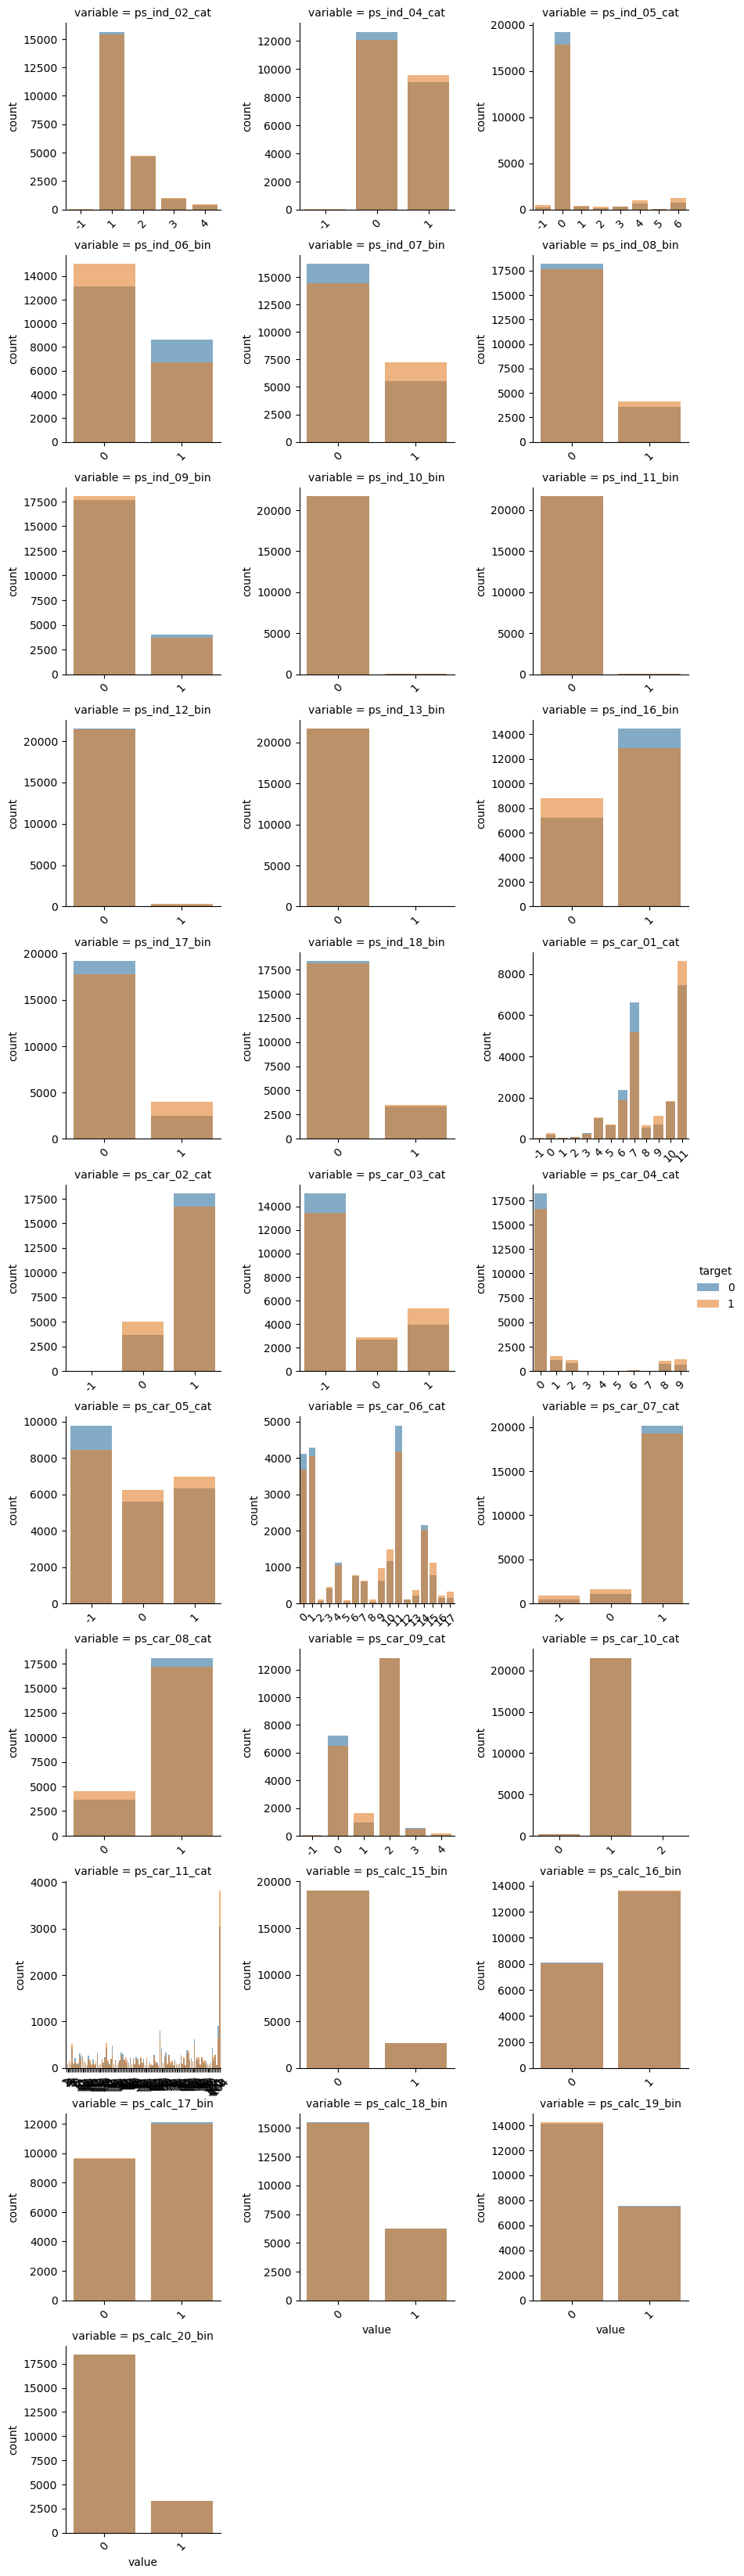

In [17]:

f = pd.melt(train_data, id_vars=['target'], value_vars=CAT_COLS)

# 使用Seaborn的FacetGrid并直接映射sns.countplot
g = sns.FacetGrid(f, col="variable", hue="target", col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.countplot, "value", alpha=0.6).add_legend()

# 循环遍历每个轴并旋转x轴标签
for ax in g.axes.flat:
    # 获取当前x轴的标签
    labels = ax.get_xticklabels()
    # 设置新的x轴标签，带有旋转
    ax.set_xticklabels(labels, rotation=45)

plt.show()

某些二元特征极度偏斜：如 ps_ind_10_bin ~ ps_ind_13_bin 有 99%以上 的样本取值为0，仅 ~1% 为1 

ps_car_11_cat 竟然有 104 种不同的类别，且分布相对长尾（部分类别频数较低）。

  ps_car_01_cat、ps_car_06_cat 等 。对于**高基数（high cardinality）**分类特征，如果直接做独热编码（one-hot），维度会非常高，增加过拟合风险。

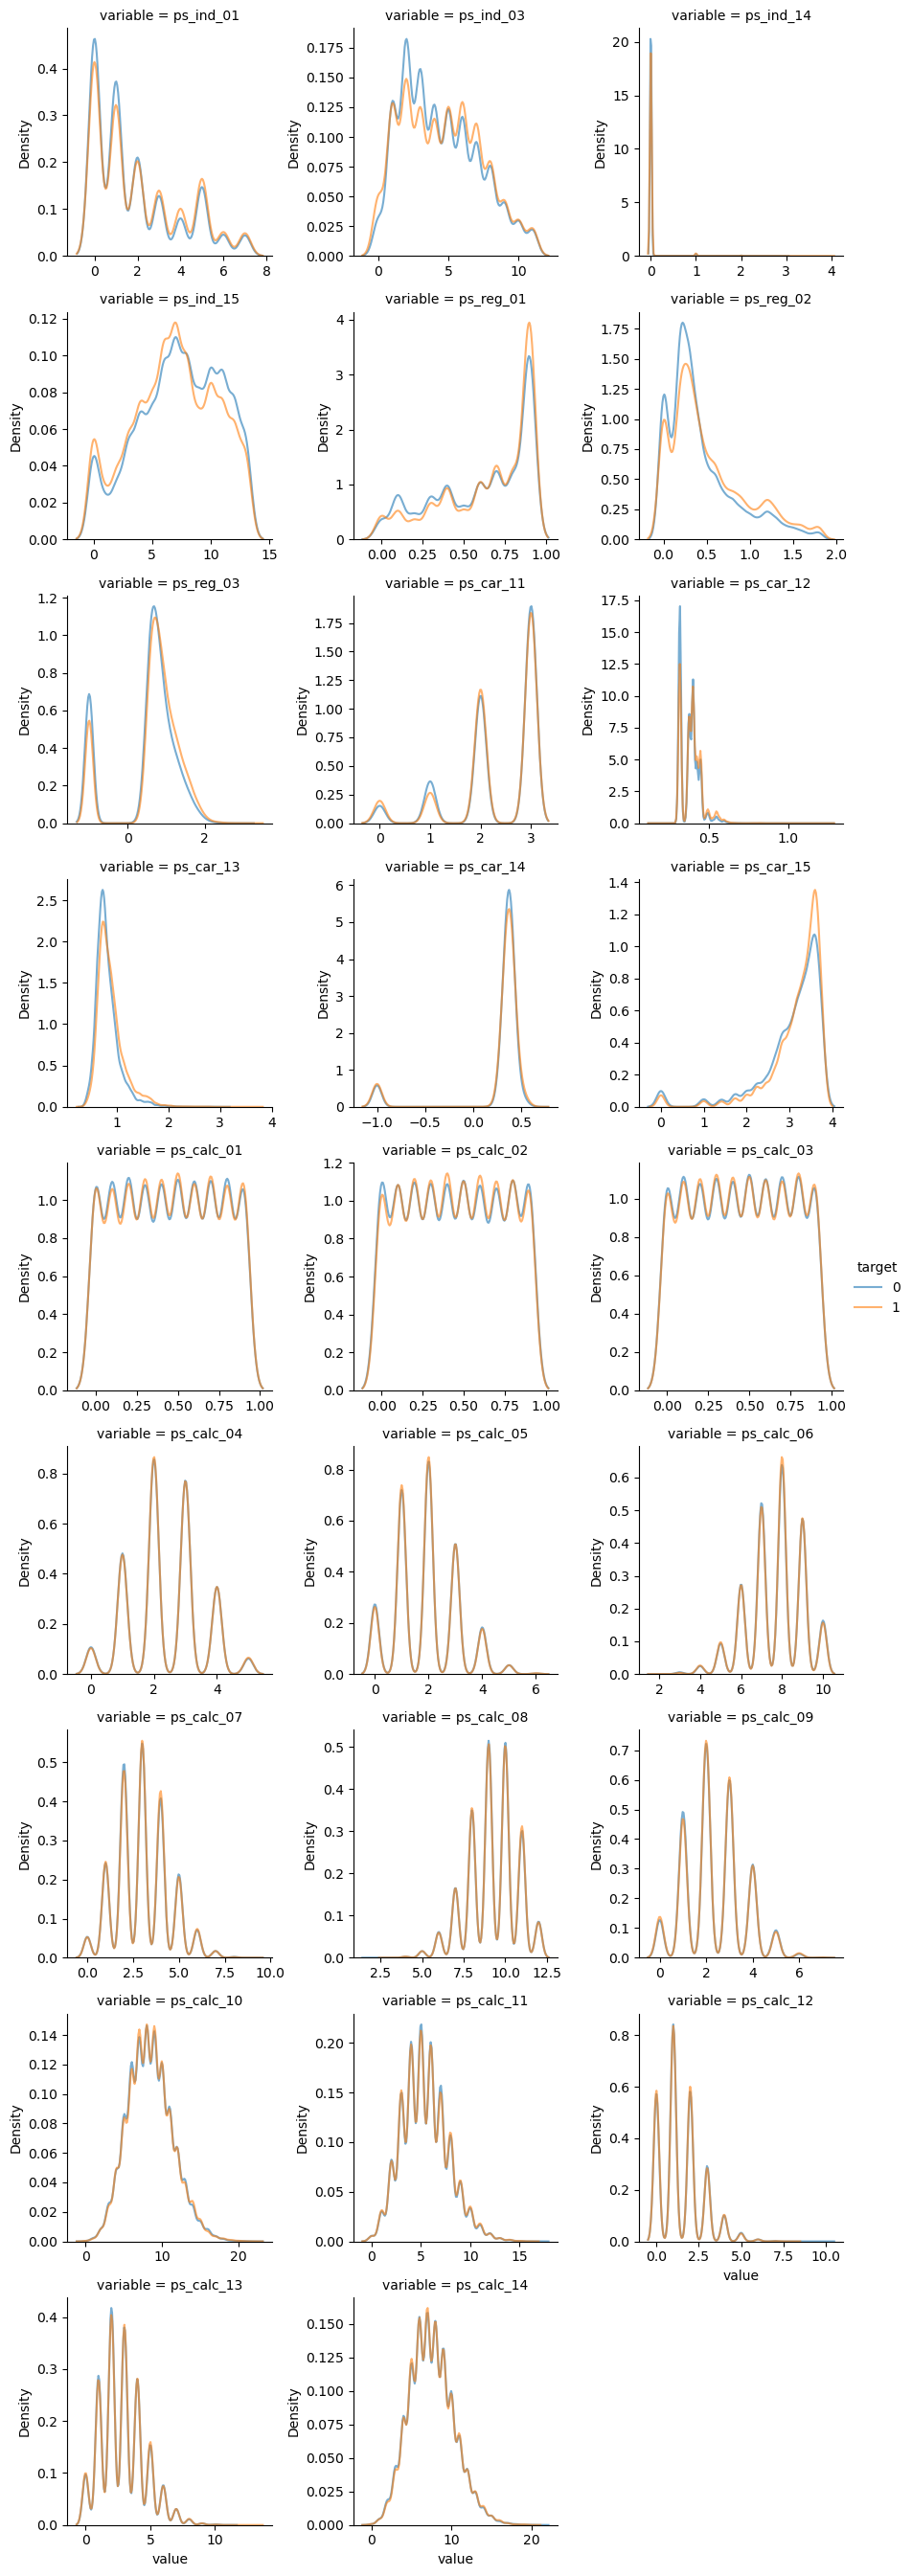

In [18]:
# # 查看连续数据的分布

f = pd.melt(train_data, id_vars=['target'], value_vars=NUM_COLS)
g = sns.FacetGrid(f, col="variable", hue="target", col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.kdeplot, "value", alpha=0.6).add_legend()

.corr()

* 'pearson'：标准的皮尔逊相关系数。
* 'kendall'：Kendall Tau 相关系数。
* 'spearman'：Spearman 秩相关系数。

ps_ind_06_bin    -0.092108
ps_car_02_cat    -0.078710
ps_car_07_cat    -0.077897
ps_ind_16_bin    -0.075604
ps_ind_15        -0.058651
ps_car_08_cat    -0.051491
ps_ind_09_bin    -0.023153
ps_car_14        -0.014422
ps_calc_19_bin   -0.004455
ps_calc_12       -0.004344
ps_car_11        -0.004257
ps_calc_17_bin   -0.003432
ps_calc_15_bin   -0.002952
id               -0.001625
ps_calc_09       -0.000575
ps_calc_05       -0.000544
ps_calc_06       -0.000381
ps_calc_20_bin    0.000644
ps_ind_10_bin     0.001001
ps_ind_11_bin     0.001013
ps_calc_08        0.001655
ps_calc_18_bin    0.001782
ps_calc_11        0.002650
ps_calc_03        0.003002
ps_calc_16_bin    0.003147
ps_calc_04        0.003508
ps_calc_02        0.003559
ps_calc_07        0.003750
ps_calc_10        0.003866
ps_calc_01        0.004233
ps_calc_13        0.004283
ps_calc_14        0.004587
ps_ind_13_bin     0.005435
ps_car_10_cat     0.005511
ps_ind_02_cat     0.008742
ps_ind_18_bin     0.012982
ps_ind_14         0.015939
p

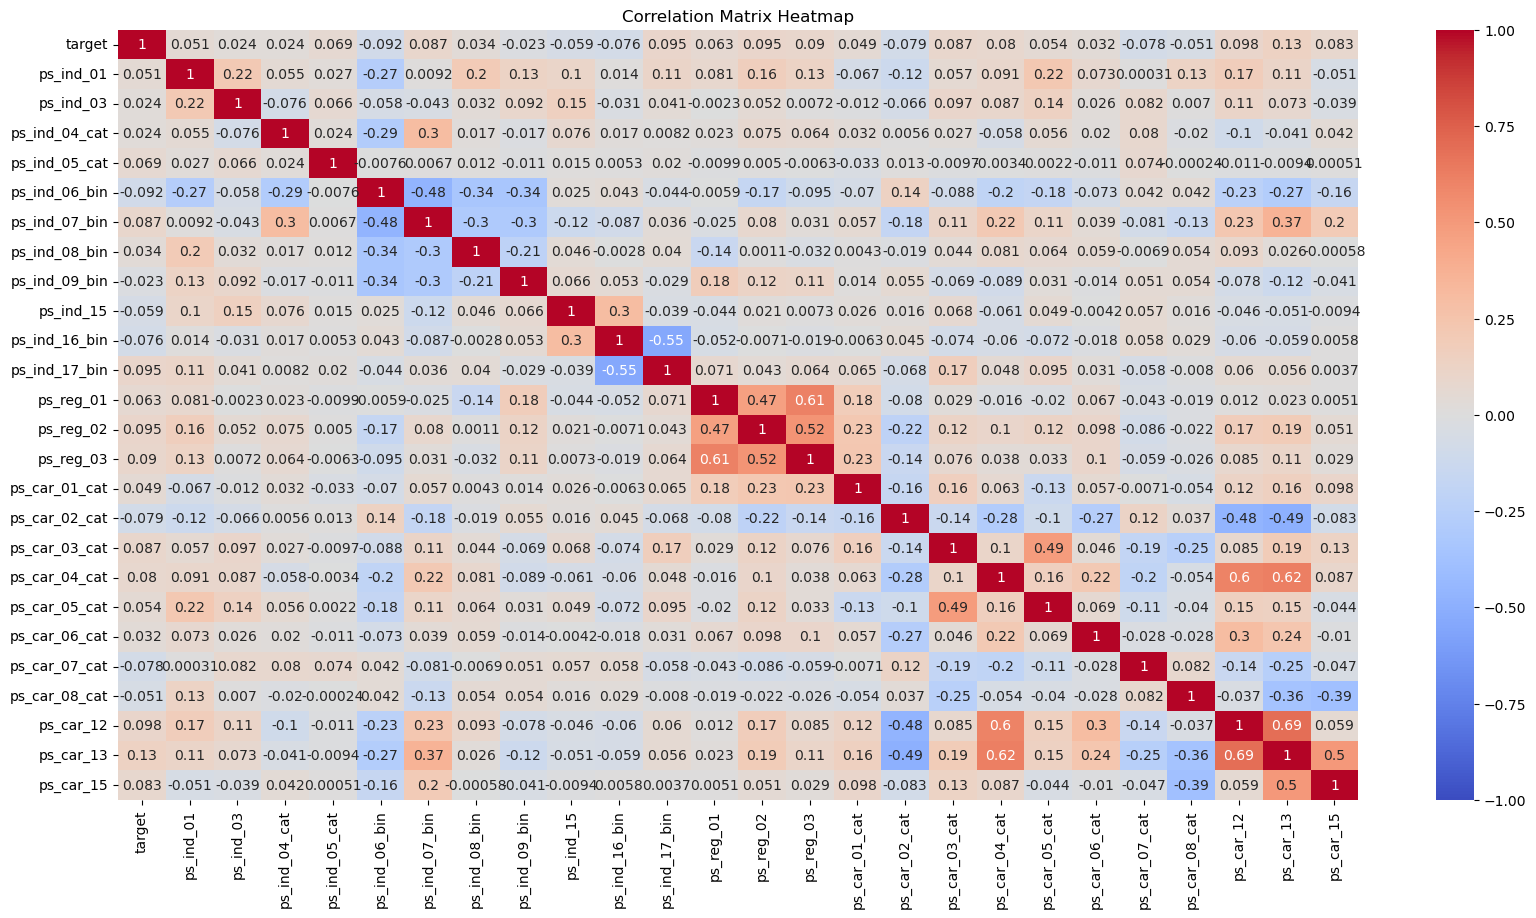

In [19]:

CorrDf = pd.DataFrame()
CorrDf = train_data.corr(method='pearson', min_periods=1)

#只显示与 target 相关性较高的特征，从而使得图表更加简洁和易于理解
print(CorrDf['target'].sort_values())
high_corr_features = CorrDf['target'].abs() > 0.02
corr_matrix_filtered = CorrDf.loc[high_corr_features, high_corr_features]

plt.figure(figsize=(20, 10))  
sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# 显示图表
plt.title('Correlation Matrix Heatmap')
plt.show()

特征间冗余度不高，大部分特征提供的信息彼此比较独立

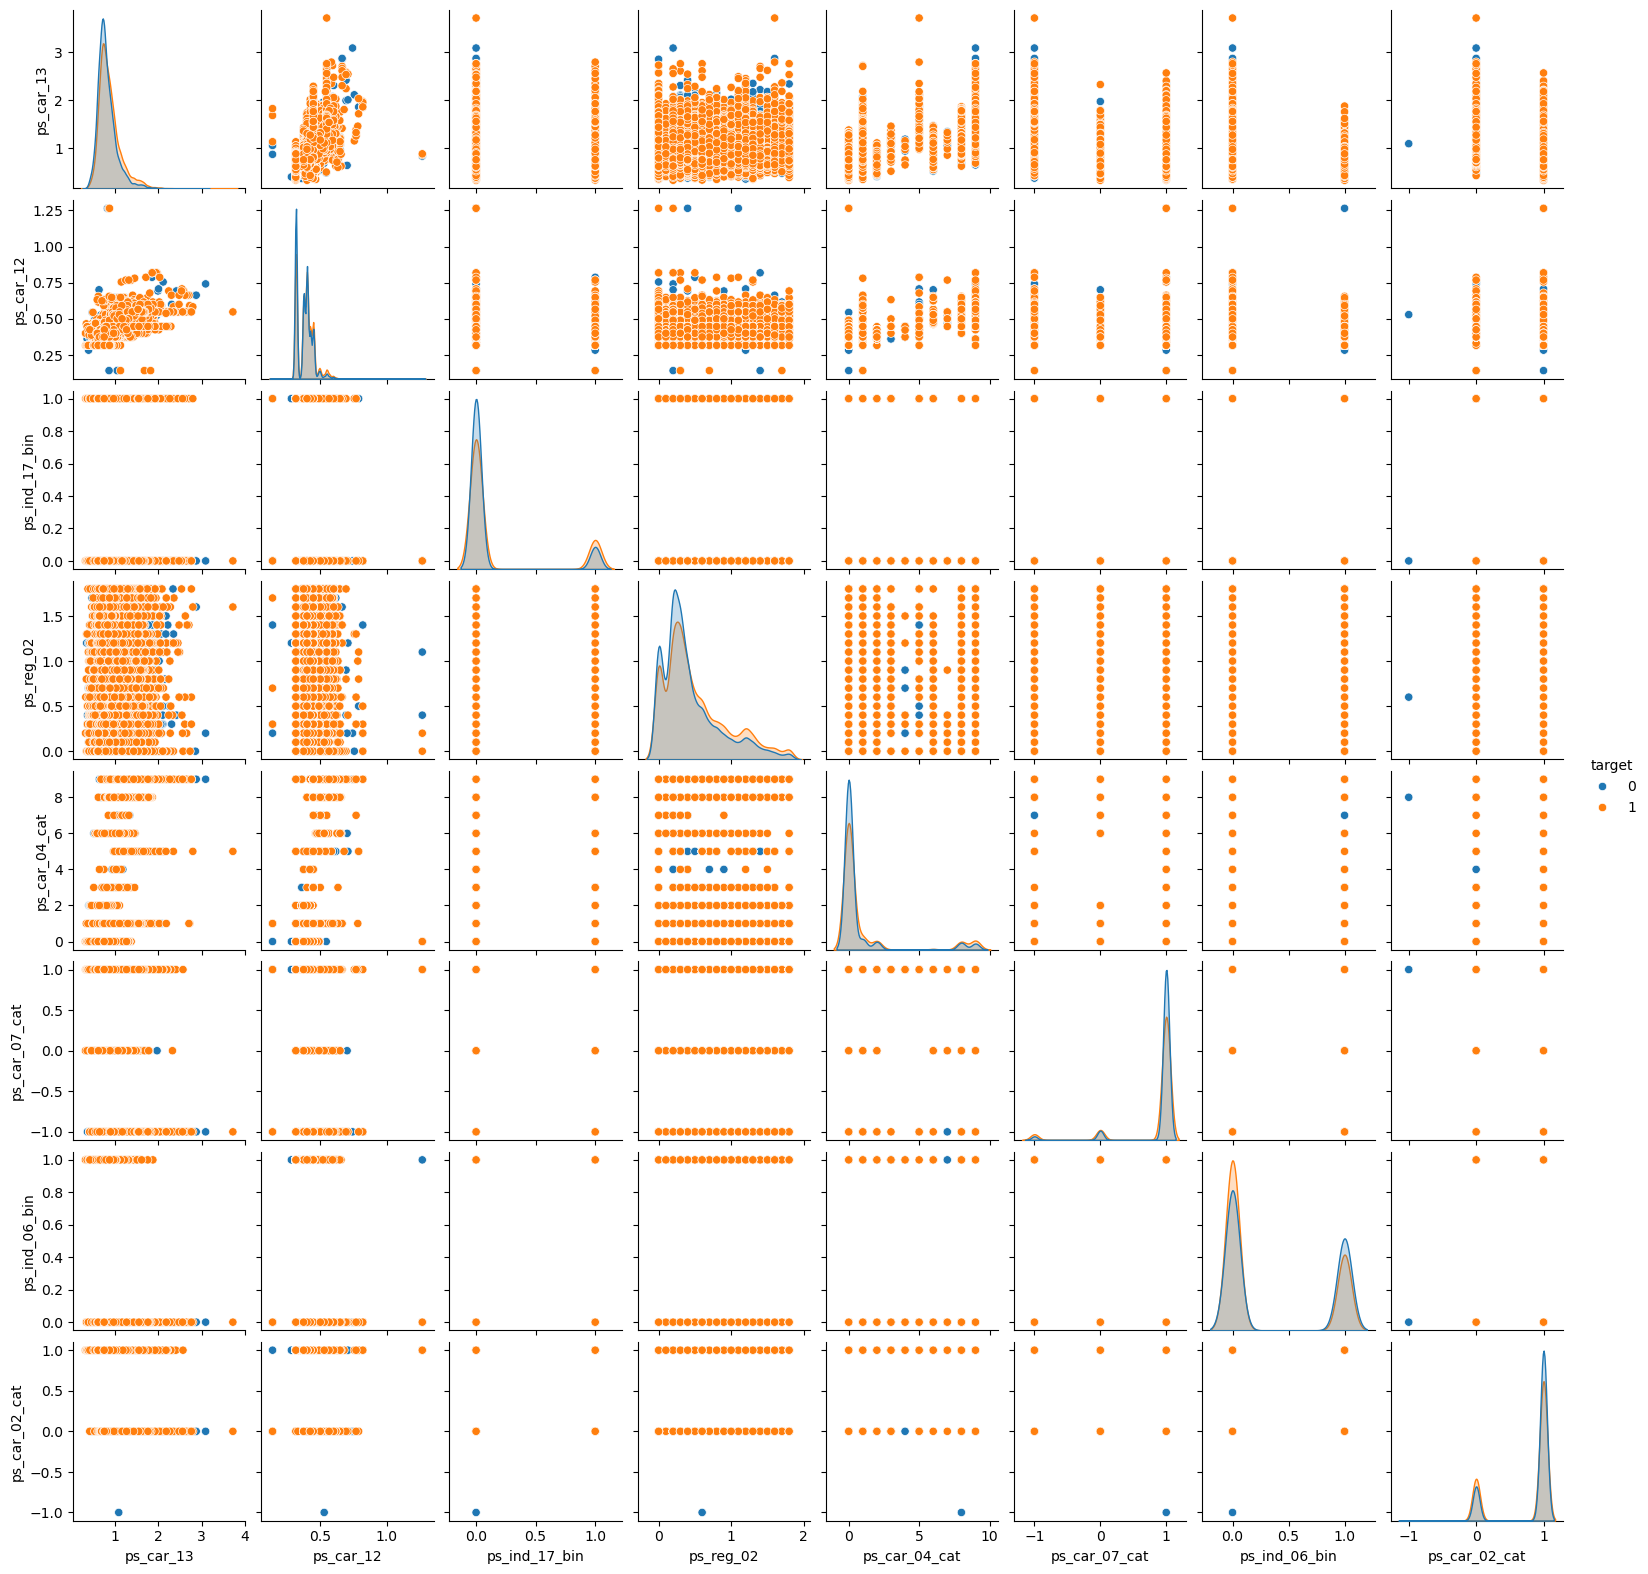

In [20]:

c = ['ps_car_13','ps_car_12','ps_ind_17_bin','ps_reg_02','ps_car_04_cat','ps_car_07_cat','ps_ind_06_bin','ps_car_02_cat']
sns.pairplot(train_data, vars=c, hue='target', height=2.0)
plt.show()


TODO:
1. -1的缺失值需要处理 占比较大的保留-1，占比较小的填充

| 特征名 | 数值 |
| --- | --- |
|ps_ind_02_cat : 216 -- 0.0004 |  |
|ps_ind_04_cat : 83 -- 0.0001 | |
|ps_ind_05_cat : 5809 -- 0.0098 | |
|ps_reg_03 : 107772 -- 0.1811 | |
|ps_car_01_cat : 107 -- 0.0002 | |
|ps_car_02_cat : 5 -- 0.0000 | |
|ps_car_03_cat : 411231 -- 0.6909 | retain |
|ps_car_05_cat : 266551 -- 0.4478 | retain |
|ps_car_07_cat : 11489 -- 0.0193 | |
|ps_car_09_cat : 569 -- 0.0010 | |
|ps_car_11 : 5 -- 0.0000 | |
|ps_car_12 : 1 -- 0.0000 | |
|ps_car_14 : 42620 -- 0.0716       | |

2. 数据不平衡需要处理
   


3. drop相关性不高的数据，主要是calc类型
4. 类别较多的数据需要处理  
   
| 特征名 | 数值 |
| --- | --- |
| ps_car_13 | 70482 |
| ps_car_14 | 850 |
| ps_reg_03 | 5013 |

# Data Process

In [122]:
# 整合数据，可以一起处理
train_data = pd.concat([df_majority, df_minority], axis=0)
full_data = pd.concat([train_data,test_data],ignore_index=True)

In [123]:
retainCols = ['ps_car_03_cat','ps_car_05_cat']
for col in retainCols:
    if col in MISSING_COLS:
        MISSING_COLS.remove(col)

for col in MISSING_COLS:
    if (full_data[col].isin([-1]).sum())>0 and ('cat' in col or 'bin' in col):
        full_data[col].fillna(full_data[col].mode()[0], inplace=True)
    elif (full_data[col].isin([-1]).sum())>0 and 'cat' not in col and 'bin' not in col:
        full_data[col].fillna(full_data[col].median(), inplace=True)
        full_data[col + '_missing'] = full_data[col].isnull().astype(int)
        print(col + '_missing')

ps_reg_03_missing
ps_car_11_missing
ps_car_12_missing
ps_car_14_missing


In [124]:
# Data Drop
DROP_COLS=[]
# 删除指定列
for col in train_data.columns:
    if 'calc' in col:
        DROP_COLS.append(col)                              
DROP_COLS.extend(['ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin'])


full_data.drop(DROP_COLS, axis=1, inplace=True)

In [125]:
# Data Transformation
# 对每个分类特征应用标签编码
for col in CAT_COLS:
    if col in full_data.columns:
        full_data[col] = pd.Categorical(full_data[col])

In [126]:
full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488028 entries, 0 to 1488027
Data columns (total 39 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   id                 1488028 non-null  int64   
 1   target             595212 non-null   float64 
 2   ps_ind_01          1488028 non-null  int64   
 3   ps_ind_02_cat      1488028 non-null  category
 4   ps_ind_03          1488028 non-null  int64   
 5   ps_ind_04_cat      1488028 non-null  category
 6   ps_ind_05_cat      1488028 non-null  category
 7   ps_ind_06_bin      1488028 non-null  category
 8   ps_ind_07_bin      1488028 non-null  category
 9   ps_ind_08_bin      1488028 non-null  category
 10  ps_ind_09_bin      1488028 non-null  category
 11  ps_ind_14          1488028 non-null  int64   
 12  ps_ind_15          1488028 non-null  int64   
 13  ps_ind_16_bin      1488028 non-null  category
 14  ps_ind_17_bin      1488028 non-null  category
 15  ps_ind_18_bin  

In [127]:
# Data Split
from sklearn.model_selection import train_test_split

target_column = 'target'
if target_column in full_data.columns:
    # 筛选出 target 列中有值的行作为训练集
    train_data = full_data[pd.notnull(full_data[target_column])].reset_index(drop=True)
    print(train_data.shape)
    # 筛选出 target 列中为空的行作为测试集
    test_data = full_data[full_data[target_column].isnull()].drop(columns=[target_column]).reset_index(drop=True)
else:
    print("指定的 target 列在数据集中找不到，请检查列名。")



(595212, 39)


In [128]:
print(train_data.shape)
train_data.head()

(595212, 39)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_reg_03_missing,ps_car_11_missing,ps_car_14_missing,ps_car_12_missing
0,7,0.0,2,2,5,1,0,0,1,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0,0,0,0
1,9,0.0,1,1,7,0,0,0,0,1,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0,0,0,0
2,13,0.0,5,4,9,1,0,0,0,1,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0,0,0,0
3,16,0.0,0,1,2,0,0,1,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0,0,0,0
4,17,0.0,0,2,0,1,0,1,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0,0,0,0


In [129]:
print(test_data.shape)
test_data.head()

(892816, 38)


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_reg_03_missing,ps_car_11_missing,ps_car_14_missing,ps_car_12_missing
0,0,0,1,8,1,0,0,1,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0,0,0,0
1,1,4,2,5,1,0,0,0,0,1,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0,0,0,0
2,2,5,1,3,0,0,0,0,0,1,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0,0,0,0


In [130]:
X = train_data.drop('target', axis=1)  # 删除目标列，并将其余部分作为特征
Y = train_data['target']               # 目标变量

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42) 

# Model

In [131]:

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

def normalized_gini(y_true, y_pred):
    # 计算AUC
    auc = roc_auc_score(y_true, y_pred)
    
    # 根据AUC计算原始Gini系数
    gini_coefficient = 2 * auc - 1
    
    # 计算正类样本的比例
    frac_pos = np.sum(y_true) / len(y_true)
    
    # 理论上Gini系数的最大值
    max_gini = (1 - frac_pos) / 2
    
    # 如果max_gini为0，则返回gini_coefficient；否则，返回标准化后的Gini系数
    if max_gini == 0:
        return gini_coefficient
    else:
        return gini_coefficient / max_gini

# 创建自定义评分器
gini_scorer = make_scorer(normalized_gini, greater_is_better=True)

In [ ]:
#导入机器学习算法库
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV ,cross_val_score,StratifiedKFold


In [ ]:


#设置kfold，交叉采样法拆分数据集
kfold=StratifiedKFold(n_splits=5)

#汇总不同模型算法
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,
                                      X,Y,
                                      scoring=gini_scorer,
                                      cv=kfold,
                                      n_jobs=-1))

    
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
#汇总数据
cvResDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','LR','LinearDiscrimiAna']})

print(cvResDf)


In [ ]:

parameters ={'n_estimators':[10,50,100,200,300,400,500],
             'criterion':['friedman_mse', 'squared_error'],
             'max_features':['sqrt','log2'],
             'min_samples_split': [2, 5, 10], 
             'min_samples_leaf': [1, 2, 4],  
             'learning_rate': [0.01, 0.1, 0.2],  
             }
#n_estimators 模型中基础估计器（通常是决策树）的数量。
model =GradientBoostingClassifier()
grid_search =GridSearchCV(model,parameters,scoring=gini_scorer,n_jobs=-1) 

grid_search.fit(X_train, Y_train)
print('best parameters:',grid_search.best_params_)
print('best score:',grid_search.best_score_)
# 预测
y_pred_rf = grid_search.predict(X_val)
print("GB 验证集 AUC:", roc_auc_score(Y_val, y_pred_rf))
print("GB 验证集 gini:", normalized_gini(Y_val, y_pred_rf))



[0.9704686  0.96553321 0.96759281 ... 0.95031738 0.96915797 0.93521798]
LightGBM 验证集 AUC: 0.6332959759978845
LightGBM 验证集 gini: 1.0635082559389897


In [132]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# 定义模型
lgb_model = LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

# 指定分类特征列索引
cat_feat_indices = [X_train.columns.get_loc(c) for c in CAT_COLS if c in X_train.columns]

# 定义参数网格
param_grid = {
    'n_estimators': [100,200,300,400],
    'learning_rate': [0.01,0.02, 0.05, 0.1,],
    'num_leaves': [4,8,16, 32],
    'max_depth': [20,50, 80,100],
    'subsample': [ 0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.1,0.3],
    'reg_lambda': [0.1,0.3],
    'scale_pos_weight': [1/ RATIO], 
}



# 初始化 GridSearchCV
grid_search = RandomizedSearchCV (
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=50,  
    cv=10,        
    verbose=1,
    n_jobs=-1
)

# 拟合模型
grid_search.fit(
    X_train,
    Y_train,
    eval_set=[(X_val, Y_val)],
    eval_metric='auc',
    categorical_feature=cat_feat_indices,
    callbacks=[lgb.early_stopping(stopping_rounds=50)], 
    feature_name='auto',  
  
)

# 输出最佳参数和得分
print("最佳参数:", grid_search.best_params_)
print("最佳验证集 AUC:", grid_search.best_score_)

# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict_proba(X_val)[:, 1]

# 计算验证集的 AUC 和 gini
print(y_pred_rf)
print("LightGBM 验证集 AUC:", roc_auc_score(Y_val, y_pred_rf))
print("LightGBM 验证集 gini:", normalized_gini(Y_val, y_pred_rf))

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 17290, number of negative: 458879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036311 -> initscore=-3.278658
[LightGBM] [Info] Start training from score -3.278658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [ ]:


lgb_model = LGBMClassifier(n_estimators=200, learning_rate=0.01,
                           num_leaves=32, max_depth=100,
                           subsample=0.8, colsample_bytree=0.8,
                           reg_alpha=0.1, reg_lambda=0.1,
                           scale_pos_weight=RATIO,
                           random_state=42, n_jobs=-1,verbose=0)
# 指定分类特征列索引
cat_feat_indices = [X_train.columns.get_loc(c) for c in CAT_COLS if c in X_train.columns] 
lgb_model.fit(
    X_train, 
    Y_train, 
    eval_set=[(X_val, Y_val)], 
    callbacks=[lgb.early_stopping(stopping_rounds=50)],  
    categorical_feature=cat_feat_indices, 
    feature_name='auto'
     
)
y_pred_rf = lgb_model.predict_proba(X_val)[:, 1]

print("LightGBM 验证集 AUC:", roc_auc_score(Y_val, y_pred_rf))
print("LightGBM 验证集 gini:", normalized_gini(Y_val, y_pred_rf))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [96]:

from xgboost import XGBClassifier



# 定义模型
xgb_model = XGBClassifier(
    objective='binary:logistic',  # 二分类任务
    eval_metric='auc',           # 使用 AUC 作为评估指标
    enable_categorical=True, 
    gamma=0,
    random_state=42,             # 固定随机种子
    n_jobs=-1                    # 使用所有 CPU 核心
)

# 定义超参数网格
param_grid = {
    'n_estimators': [100,200,300, 500],          # 树的数量
    'max_depth': [3,5,10,15],                  # 树的最大深度
    'learning_rate': [0.02,0.05, 0.1],      # 学习率
    'min_child_weight': [5, 10],
    'subsample': [ 0.8],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'scale_pos_weight': [RATIO]              # 正负样本权重比（根据你的数 据设置）
}



grid_search = RandomizedSearchCV (
    estimator=xgb_model,
    param_distributions=param_grid,  # 注意：这里用的是 param_distributions 而不是 param_grid
    n_iter=20,                      # 随机搜索 20 次
    cv=10,  # 交叉验证折数
    verbose=1,
    n_jobs=-1  # 并行计算
)

# 训练模型
grid_search.fit(X_train, Y_train)

# 输出最佳参数和得分
print("最佳参数:", grid_search.best_params_)
print("最佳验证集 AUC:", grid_search.best_score_)

# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict_proba(X_val)[:, 1]



print("XGBoost 验证集 AUC:", roc_auc_score(Y_val, y_pred_rf))
print("XGBoost 验证集 gini:", normalized_gini(Y_val, y_pred_rf))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
最佳参数: {'subsample': 0.8, 'scale_pos_weight': 26.43671061122891, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
最佳验证集 AUC: 0.5241181885991143
XGBoost 验证集 AUC: 0.5959221195636495
XGBoost 验证集 gini: 0.765319172761278


In [115]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=800, max_depth=15, learning_rate=0.1,
                          subsample=0.8,colsample_bytree=0.8,
                          min_child_weight=5, gamma=0,
                          scale_pos_weight=RATIO,
                          objective='binary:logistic',  eval_metric='auc',
                          enable_categorical=True, random_state=42, n_jobs=-1)
xgb_model.fit(
    X_train, 
    Y_train, 
    eval_set=[(X_val, Y_val)], 
    verbose=0)
# 预测验证集并计算AUC
y_pred_rf = xgb_model.predict_proba(X_val)[:,1]

print("XGBoost 验证集 AUC:", roc_auc_score(Y_val, y_pred_rf))
print("XGBoost 验证集 gini:", normalized_gini(Y_val, y_pred_rf))   

XGBoost 验证集 AUC: 0.5971062008911843
XGBoost 验证集 gini: 0.7747664216981583


In [117]:
test_data.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_reg_03_missing,ps_car_11_missing,ps_car_14_missing
0,0,0,1,8,1,0,0,1,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0,0,0
1,1,4,2,5,1,0,0,0,0,1,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0,0,0
2,2,5,1,3,0,0,0,0,0,1,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0,0,0


In [113]:
def save_data(y_pred,filename):
    submission=pd.DataFrame ( {
    "id" : test_data [ "id" ],
    "target" : y_pred.astype (int)
    })
    submission.to_csv ( filename+'_result.csv',index=False)
y_pred_rf = lgb_model.predict_proba(test_data)[:, 1] 
threshold = 0.5  # 阈值
y_pred_class = (y_pred_rf< threshold).astype(int)  # 将概率转换为类别标签
count_of_ones = y_pred_class.sum()  
print("预测为1的数量:", count_of_ones)
save_data(y_pred_class,'random')
# 评估

预测为1的数量: 473
